In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene

In [11]:
def check_normality(data):
    try:
        stat, p_value = shapiro(data.sample(min(len(data), 5000)))
        return p_value > 0.05
    except:
        return False


In [12]:
def check_variable_type(data, column):
    # 결측치가 아닌 고유값 수 계산
    unique_count = data[column].dropna().nunique()
    if data[column].dtype in ['int64', 'float64'] and unique_count > 10:
        return "연속형"
    return "범주형"

In [14]:
def auto_analysis(df, var1, var2):
    """
    두 변수를 입력받아 자동으로 적절한 통계 분석을 수행하는 함수
    """
    try:
        print(f"\n[{var1} - {var2} 분석]")
        print("-" * 50)
        
        # 1. 변수 존재 확인
        if var1 not in df.columns or var2 not in df.columns:
            raise ValueError(f"컬럼을 찾을 수 없습니다: {var1} 또는 {var2}")
        
        # 2. 변수 유형 확인
        type1 = check_variable_type(df, var1)
        type2 = check_variable_type(df, var2)
        print(f"변수 유형: {var1}({type1}) - {var2}({type2})")
        
        # 3. 결측치 확인 및 처리
        df_clean = df.dropna(subset=[var1, var2])
        missing_ratio = (1 - len(df_clean) / len(df)) * 100
        print(f"결측치 비율: {missing_ratio:.1f}%")
        
        if len(df_clean) == 0:
            raise ValueError("유효한 데이터가 없습니다 (모두 결측치)")
        
        analysis_result = None  # 분석 결과를 저장할 변수
        
        # 4. 분석 케이스 분류
        if type1 == "연속형" and type2 == "연속형":
            # 연속형-연속형: 상관분석
            correlation, p_value = stats.pearsonr(df_clean[var1], df_clean[var2])
            analysis_result = {
                'method': '상관분석',
                'statistic': correlation,
                'p_value': p_value,
                'additional': f"상관계수: {correlation:.3f}"
            }
            
            # 시각화
            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=df_clean, x=var1, y=var2)
            plt.title(f'{var1} vs {var2} Scatter Plot')
            plt.show()
            
        elif type1 == "범주형" and type2 == "범주형":
            # 범주형-범주형: 카이제곱 검정
            contingency = pd.crosstab(df_clean[var1], df_clean[var2])
            chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency)
            analysis_result = {
                'method': '카이제곱 검정',
                'statistic': chi2_stat,
                'p_value': p_value,
                'additional': f"자유도: {dof}"
            }
            
            print("\n[교차표 비율]")
            print(contingency.div(contingency.sum(axis=1), axis=0) * 100)
            
            # 시각화
            plt.figure(figsize=(12, 6))
            sns.heatmap(contingency, annot=True, fmt='d', cmap='YlOrRd')
            plt.title(f'{var1} vs {var2} Heatmap')
            plt.show()
            
        else:
            # 범주형-연속형: ANOVA 또는 t-test
            cat_var = var1 if type1 == "범주형" else var2
            cont_var = var2 if type1 == "범주형" else var1
            
            groups = [group for name, group in df_clean.groupby(cat_var)[cont_var]]
            
            if len(groups) == 0:
                raise ValueError("그룹이 생성되지 않았습니다")
            
            # 등분산성 검정
            if len(groups) >= 2:
                try:
                    levene_stat, levene_p = levene(*groups)
                    print(f"\n등분산성 검정 p-value: {levene_p:.3f}")
                except:
                    print("\n등분산성 검정을 수행할 수 없습니다")
            
            if len(groups) == 2:
                # t-test
                stat, p_value = stats.ttest_ind(*groups)
                method = "t-test"
            else:
                # ANOVA
                stat, p_value = stats.f_oneway(*groups)
                method = "ANOVA"
                
            analysis_result = {
                'method': method,
                'statistic': stat,
                'p_value': p_value,
                'additional': f"그룹 수: {len(groups)}"
            }
            
            # 기술통계량
            desc_stats = df_clean.groupby(cat_var)[cont_var].agg(['count', 'mean', 'std'])
            print("\n[기술통계]")
            print(desc_stats)
            
            # 시각화
            plt.figure(figsize=(10, 6))
            if len(df_clean[cat_var].unique()) <= 10:
                sns.boxplot(data=df_clean, x=cat_var, y=cont_var)
                plt.xticks(rotation=45)
            plt.title(f'{cat_var} vs {cont_var} Box Plot')
            plt.show()
        
        # 5. 결과 출력
        if analysis_result:
            print(f"\n[{analysis_result['method']} 결과]")
            print(f"통계량: {analysis_result['statistic']:.3f}")
            print(f"p-value: {analysis_result['p_value']:.3f}")
            print(analysis_result['additional'])
            
            print("\n[분석 결과 해석]")
            if analysis_result['p_value'] < 0.05:
                print("→ 통계적으로 유의한 관계가 있습니다 (p < 0.05)")
            else:
                print("→ 통계적으로 유의한 관계가 없습니다 (p >= 0.05)")
        
    except Exception as e:
        print(f"\n[오류 발생] {str(e)}")
        print("분석을 완료할 수 없습니다.")


[Gender - Spending_Score 분석]
--------------------------------------------------
변수 유형: Gender(범주형) - Spending_Score(범주형)
결측치 비율: 0.0%

[교차표 비율]
Spending_Score    Average       High        Low
Gender                                         
Female          22.760887  13.420981  63.818132
Male            25.877292  16.436495  57.686212


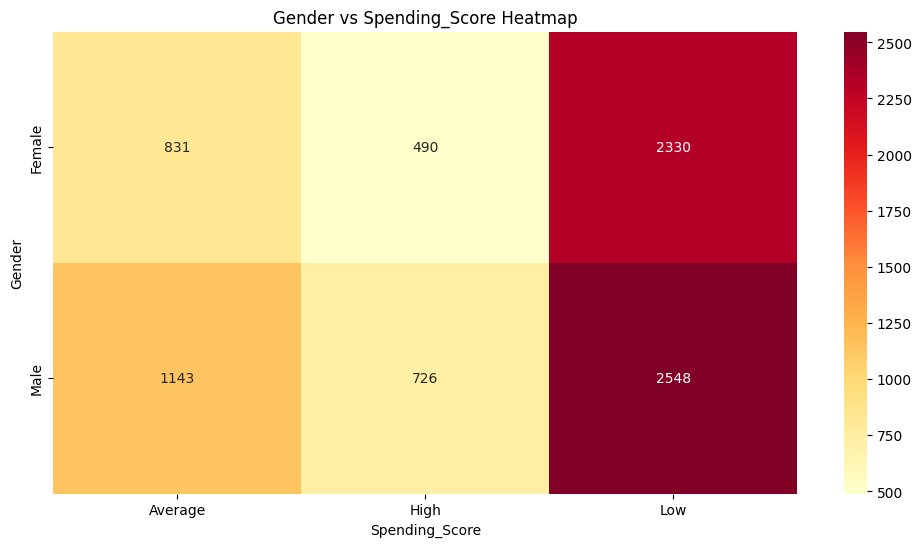


[카이제곱 검정 결과]
통계량: 32.424
p-value: 0.000
자유도: 2

[분석 결과 해석]
→ 통계적으로 유의한 관계가 있습니다 (p < 0.05)

[Ever_Married - Profession 분석]
--------------------------------------------------
변수 유형: Ever_Married(범주형) - Profession(범주형)
결측치 비율: 3.2%

[교차표 비율]
Profession       Artist     Doctor  Engineer  Entertainment  Executive  \
Ever_Married                                                             
No            22.040185  11.313756  8.253478      11.066461   1.143740   
Yes           38.792915   6.800787  9.075005      12.661273  12.027116   

Profession    Healthcare  Homemaker     Lawyer  Marketing  
Ever_Married                                               
No             35.641422   3.462133   1.236476   5.842349  
Yes             3.170785   2.799038  12.573803   2.099278  


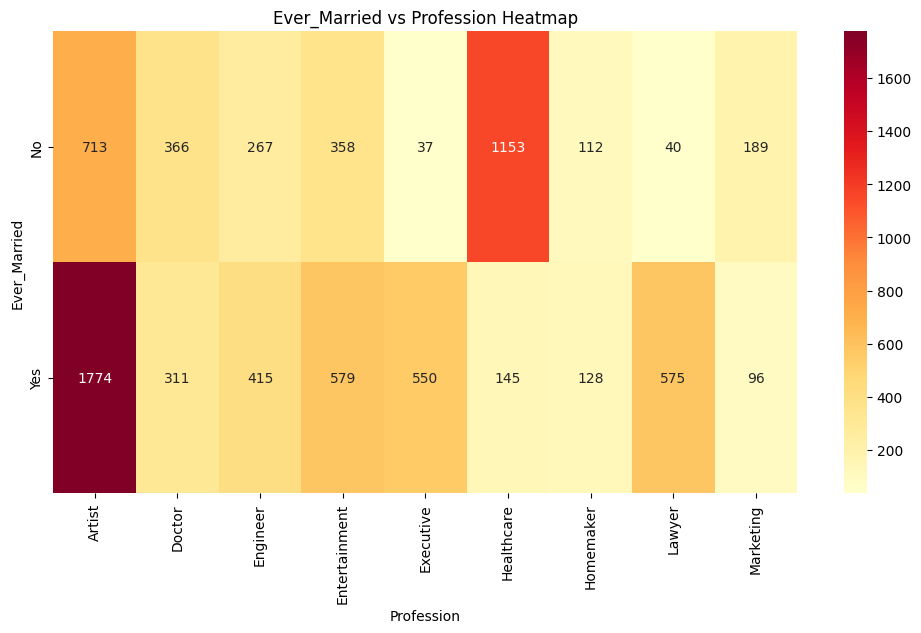


[카이제곱 검정 결과]
통계량: 2101.728
p-value: 0.000
자유도: 8

[분석 결과 해석]
→ 통계적으로 유의한 관계가 있습니다 (p < 0.05)

[Age - Spending_Score 분석]
--------------------------------------------------
변수 유형: Age(연속형) - Spending_Score(범주형)
결측치 비율: 0.0%

등분산성 검정 p-value: 0.000

[기술통계]
                count       mean        std
Spending_Score                             
Average          1974  46.868288  11.308729
High             1216  57.777138  17.743685
Low              4878  38.523165  15.861773


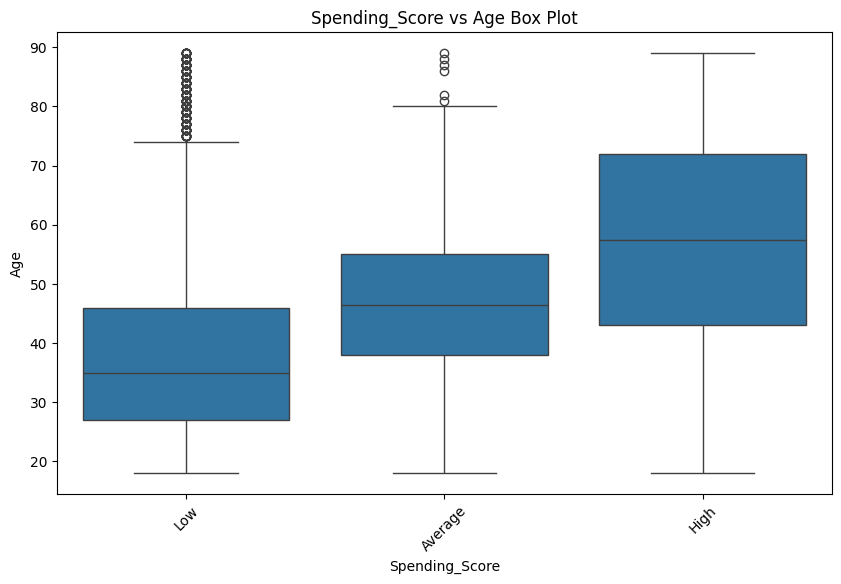


[ANOVA 결과]
통계량: 846.997
p-value: 0.000
그룹 수: 3

[분석 결과 해석]
→ 통계적으로 유의한 관계가 있습니다 (p < 0.05)

[Profession - Work_Experience 분석]
--------------------------------------------------
변수 유형: Profession(범주형) - Work_Experience(연속형)
결측치 비율: 11.5%

등분산성 검정 p-value: 0.000

[기술통계]
               count      mean       std
Profession                              
Artist          2305  2.708460  3.388225
Doctor           630  2.622222  3.513338
Engineer         628  2.595541  3.342555
Entertainment    862  2.755220  3.441793
Executive        528  2.327652  3.161172
Healthcare      1184  2.592061  3.302701
Homemaker        211  6.464455  4.058198
Lawyer           540  1.229630  2.206217
Marketing        253  2.616601  3.493651


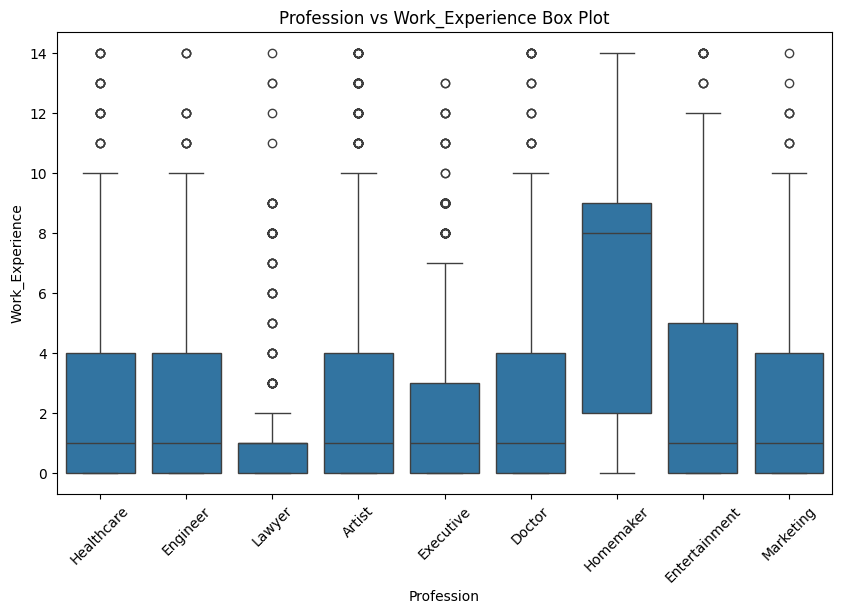


[ANOVA 결과]
통계량: 47.981
p-value: 0.000
그룹 수: 9

[분석 결과 해석]
→ 통계적으로 유의한 관계가 있습니다 (p < 0.05)

[Age - Work_Experience 분석]
--------------------------------------------------
변수 유형: Age(연속형) - Work_Experience(연속형)
결측치 비율: 10.3%


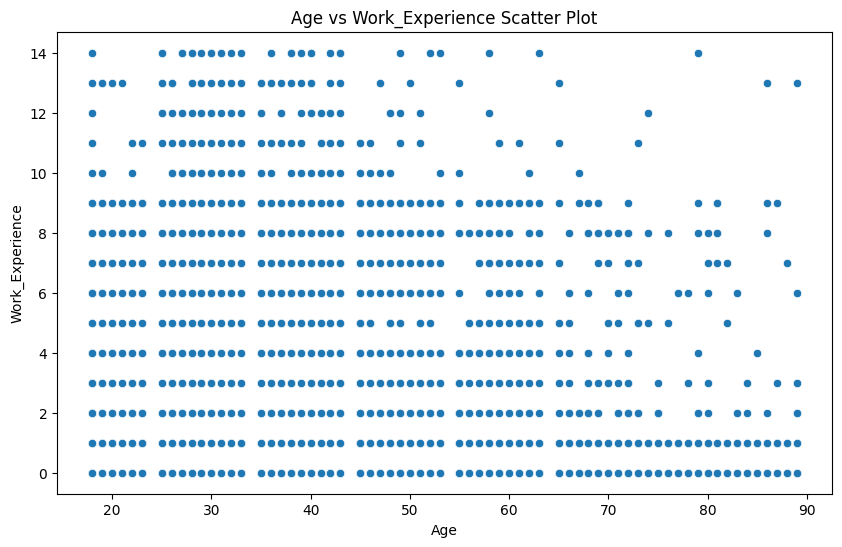


[상관분석 결과]
통계량: -0.191
p-value: 0.000
상관계수: -0.191

[분석 결과 해석]
→ 통계적으로 유의한 관계가 있습니다 (p < 0.05)

[Work_Experience - Family_Size 분석]
--------------------------------------------------
변수 유형: Work_Experience(연속형) - Family_Size(범주형)
결측치 비율: 13.6%

등분산성 검정 p-value: 0.000

[기술통계]
             count      mean       std
Family_Size                           
1.0           1306  3.185299  3.779675
2.0           2175  2.693793  3.451868
3.0           1351  2.422650  3.223486
4.0           1225  2.307755  3.123150
5.0            554  2.357401  3.109001
6.0            188  2.457447  3.436716
7.0             86  2.523256  3.104936
8.0             44  3.204545  3.915263
9.0             40  2.625000  3.446942


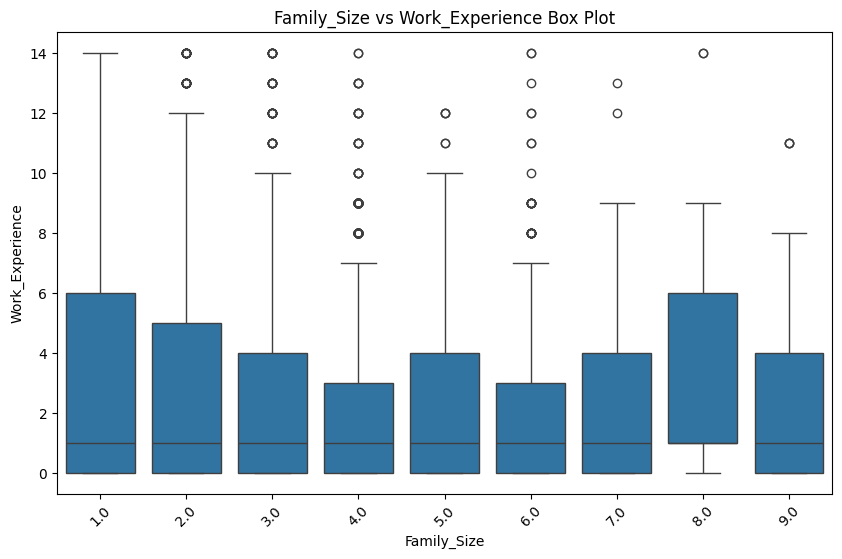


[ANOVA 결과]
통계량: 7.166
p-value: 0.000
그룹 수: 9

[분석 결과 해석]
→ 통계적으로 유의한 관계가 있습니다 (p < 0.05)


In [15]:
# 사용 예시
df = pd.read_csv('../datasets/customer-segmentation_Train.csv')

# 분석하고 싶은 두 변수 쌍을 리스트로 정의
analysis_pairs = [
    ('Gender', 'Spending_Score'),
    ('Ever_Married', 'Profession'),
    ('Age', 'Spending_Score'),
    ('Profession', 'Work_Experience'),
    ('Age', 'Work_Experience'),
    ('Work_Experience', 'Family_Size')
]

# 모든 변수 쌍에 대해 자동 분석 수행
for var1, var2 in analysis_pairs:
    auto_analysis(df, var1, var2)